In [1]:
import pandas as pd
# carregando dados de treino
df_x = pd.read_csv("./dataset/Training/TrainingAccZAxis.txt", header=None)
df_x.columns =[ "AccZAxis"]
df_y = pd.read_csv("./dataset/Training/TrainingStepsOrNot.txt", header=None)
df_y.columns =[ "Step"]

# carregando dados de teste
df_x_test = pd.read_csv("./dataset/Testing/TestingAccZAxis.txt", header=None)
df_x_test.columns =[ "AccZAxis"]
df_y_test = pd.read_csv("./dataset/Testing/TestingStepsOrNot.txt", header=None)
df_y_test.columns =[ "Step"]

<AxesSubplot:title={'center':'raw data z axis'}>

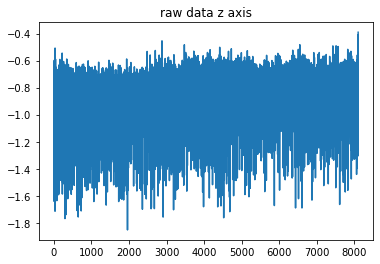

In [2]:
df_x["AccZAxis"].plot(title="raw data z axis")

<AxesSubplot:title={'center':'raw data z axis window of 10 seconds'}>

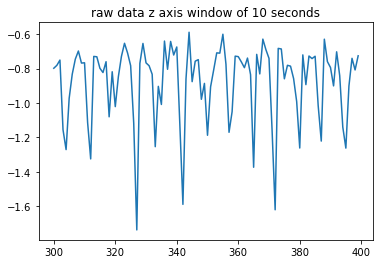

In [3]:
df_x["AccZAxis"][300:400].plot(title="raw data z axis window of 10 seconds")

In [10]:
len(df_x_test)

1389

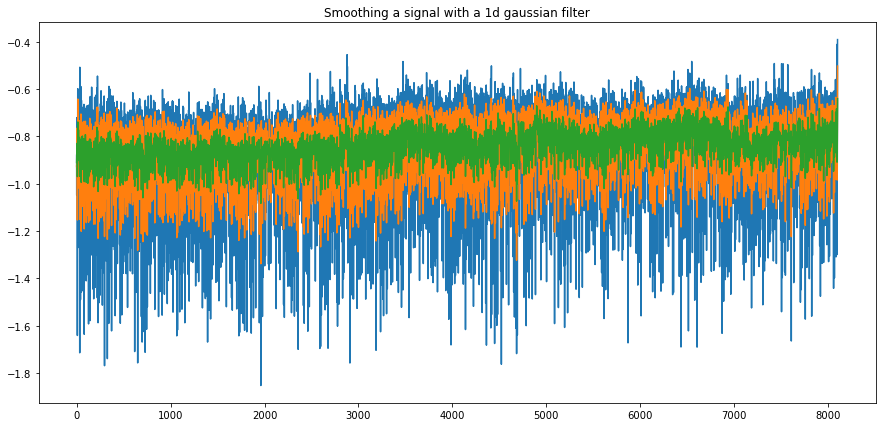

In [4]:
# code for smoothing a signal with a 1d gaussian filter
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt


plt.figure(figsize=(15,7))
plt.plot(df_x["AccZAxis"], label="raw data")
plt.plot(gaussian_filter1d(df_x["AccZAxis"], sigma=1), label="smoothed data $\sigma=1$")
plt.plot(gaussian_filter1d(df_x["AccZAxis"], sigma=2), label="smoothed data $\sigma=2$")
plt.title("Smoothing a signal with a 1d gaussian filter")
plt.show()

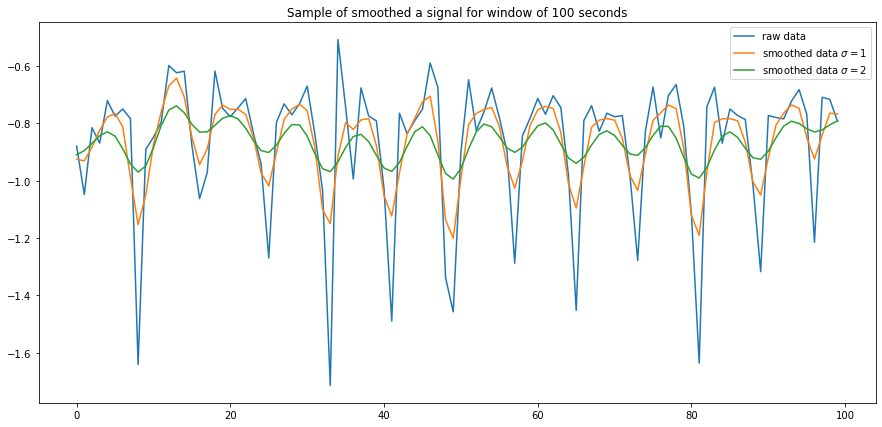

In [5]:

start = 0
end = 100
plt.figure(figsize=(15,7))
plt.plot(df_x["AccZAxis"][start:end], label="raw data")
plt.plot(gaussian_filter1d(df_x["AccZAxis"][start:end], sigma=1), label="smoothed data $\sigma=1$")
plt.plot(gaussian_filter1d(df_x["AccZAxis"][start:end], sigma=2), label="smoothed data $\sigma=2$")
plt.title("Sample of smoothed a signal for window of 100 seconds")
plt.legend()
plt.show()

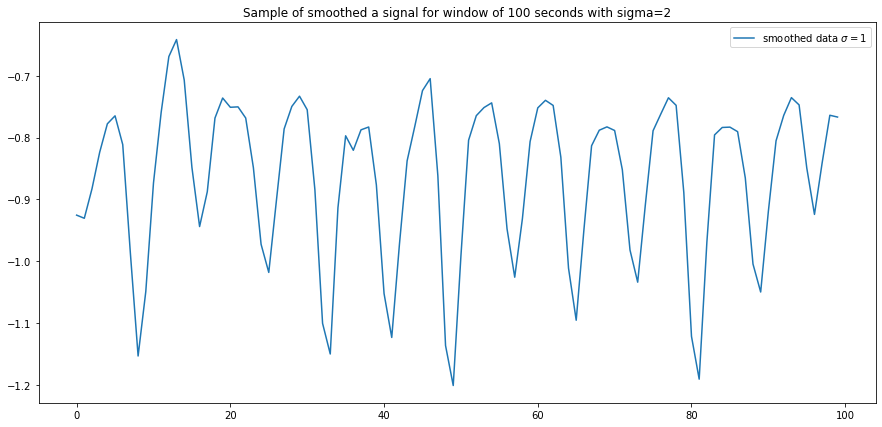

In [6]:
start = 0
end = 100
plt.figure(figsize=(15,7))
plt.plot(gaussian_filter1d(df_x["AccZAxis"][start:end], sigma=1), label="smoothed data $\sigma=1$")
plt.title("Sample of smoothed a signal for window of 100 seconds with sigma=2")
plt.legend()
plt.show()

[People around the age of 21-40 years have a cadence of about 48-60 steps per minute](https://www.mdpi.com/2504-3900/31/1/60/pdf)

That means that 1 step would occur in a range of around:
$$
stepMin = 48/60 = 0.8 \space step/s  \newline
stepMax = 60/60 = 1 \space step/s
$$

Given this information and the profile of the smoothed signal collected, I would at 10hz, we could use window sizes for step detection of around 1 second which would be about 10 samples per segmented signal, inspiration from the preprocessing protocol seen [here](https://www.mdpi.com/2504-3900/31/1/60/pdf)

(The window size used in `FAA_Proj1_Step_ANN.ipynb` was 3 which at 10Hz would mean 
0.33s which is much lower with respect to the average cadence of a person.)  

Following the gait classification paragraph in [here](https://www.mdpi.com/2504-3900/31/1/60/pdf), we will segment the signals and after that, we will 
have two versions of the dataset, one with only the segmented signals raw,
and another with feature vectors extracted from the segmented signals where we 
will extract:
- height of the peak of the accelerometer data
- mean of the acceleration
- standard deviation of the acceleration

Besides that we will also use the difference dataset from `TrainingDiffs.txt`
and apply similar segmentation and preprocessing.

For the models we will some of the architectures described [here](https://run.unl.pt/bitstream/10362/106544/1/Rodrigues_2020.pdf)

In [72]:
%load_ext autoreload
%autoreload 2
import numpy as np
from utils import dataPrepRawSignal

x_train, y_train = dataPrepRawSignal(df_x, df_y)
x_test, y_test = dataPrepRawSignal(df_x_test, df_y_test)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


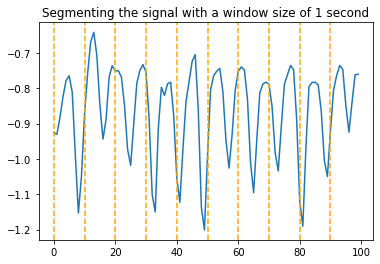

In [53]:
# Visualizing the segment windows with vertical lines in the original 
# smoothed signal
fig, ax = plt.subplots()
ax.plot(x_train.ravel()[:100], label="smoothed data")
for i in range(0,100,window_size):
    ax.axvline(x=i, color='orange', linestyle='--')
plt.title("Segmenting the signal with a window size of 1 second")
plt.show()

In [55]:
from models import *

lstm = lstm_model(n_timesteps=x_train.shape[1], n_features=1, n_outputs=1)
epochs = 500
batch_size = 64
# preprocessing the data for fitting a RNN model
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
history = lstm.fit(x_train, y_train, epochs=epochs,batch_size=batch_size)
performance = lstm.evaluate(x_test, y_test)
print(performance)

5/5 [==============================] - 0s 2ms/step - loss: 0.8547 - accuracy: 0.7204
[0.8546832203865051, 0.7204380035400391]


In [65]:
print(history.history["loss"][-1])
print(history.history["accuracy"][-1])

0.29385697841644287
0.8678614497184753


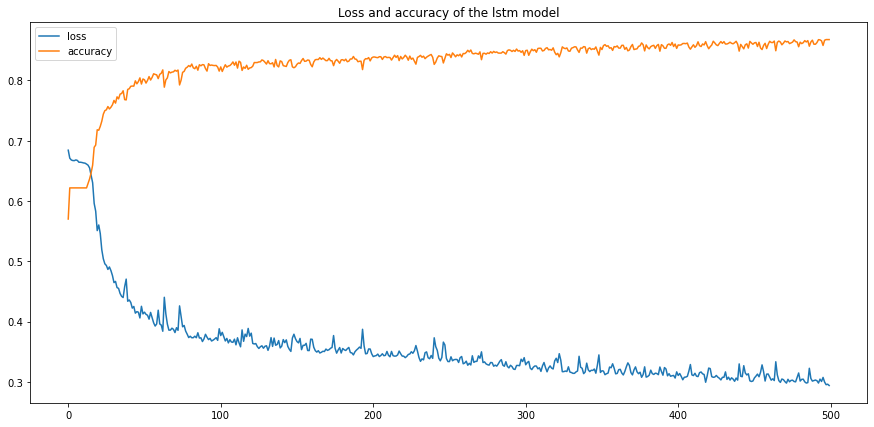

In [67]:
# plot loss and accuracy
plotPerformance(history, "lstm")

In [69]:
net = basic_neural_net(input_shape=(x_train.shape[1],))
epochs = 250
batch_size = 32
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
history = net.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
performance = net.evaluate(x_test, y_test)
print("Training Loss: ",history.history["loss"][-1])
print("Training Accuracy: ",history.history["accuracy"][-1])
print("Testing Loss: ",performance[0])
print("Testing Accuracy: ",performance[1])


5/5 [==============================] - 0s 762us/step - loss: 0.3466 - accuracy: 0.8832
Training Loss:  0.13885566592216492
Training Accuracy:  0.939431369304657
Testing Loss:  0.3465636074542999
Testing Accuracy:  0.8832116723060608


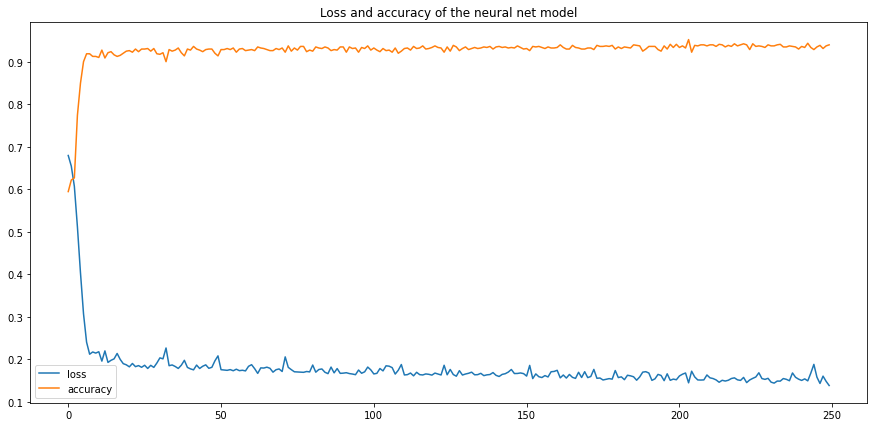

In [70]:
plotPerformance(history, "neural net")

5/5 [==============================] - 0s 793us/step - loss: 2.1704 - accuracy: 0.8832
Loss:  0.08830555528402328
Accuracy:  0.967861533164978
Testing Loss:  2.170403480529785
Testing Accuracy:  0.8832116723060608


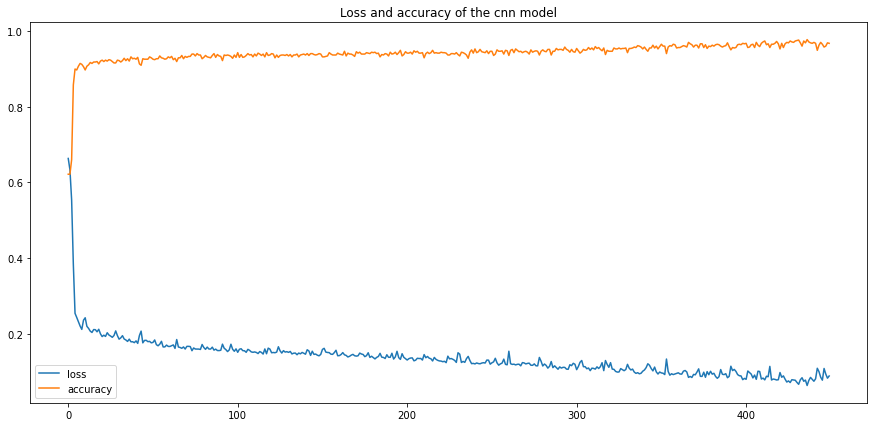

In [71]:
cnn = cnnModel((x_train.shape[1], 1))
epochs = 450
batch_size = 32
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)
history = cnn.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
performance = cnn.evaluate(x_test, y_test)
print("Loss: ",history.history["loss"][-1])
print("Accuracy: ",history.history["accuracy"][-1])
print("Testing Loss: ",performance[0])
print("Testing Accuracy: ",performance[1])
plotPerformance(history, "cnn")


These models are overfitting.

In [73]:
# Now I should apply the preprocessing and fit the model on the test data
from utils import dataPrepProcessedSignal


x_train, y_train = dataPrepProcessedSignal(df_x, df_y)
x_test, y_test = dataPrepProcessedSignal(df_x_test, df_y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(809, 3, 1)
(809,)
(137, 3, 1)
(137,)


In [75]:
net = basic_neural_net(input_shape=(x_train.shape[1],))
epochs = 250
batch_size = 32
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
history = net.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
performance = net.evaluate(x_test, y_test)
print("Training Loss: ",history.history["loss"][-1])
print("Training Accuracy: ",history.history["accuracy"][-1])
print("Testing Loss: ",performance[0])
print("Testing Accuracy: ",performance[1])

5/5 [==============================] - 0s 907us/step - loss: 0.7280 - accuracy: 0.4964
Training Loss:  0.6495556235313416
Training Accuracy:  0.6378244757652283
Testing Loss:  0.7279708981513977
Testing Accuracy:  0.49635037779808044


Processed signal performs much worst on the multilayer neural net model.

# Only thing missing is adding a vector for the diff data